# Lista 2
Aluno: Arthur Pontes de Miranda Ramos Soares

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

## Funções Auxiliares


In [5]:
def show_images(*images: np.ndarray, titles: list[str] | None = None, columns: int = 2, scale: int = 5) -> None:
    num_images = len(images)
    
    if titles is None:
        titles = [f'Image {i+1}' for i in range(num_images)]
    
    rows = (num_images + columns - 1) // columns 

    fig, axes = plt.subplots(rows, columns, figsize=(scale * columns, scale * rows))
    axes = np.array(axes).reshape(rows, columns)

    for ax, img, title in zip(axes.flat, images, titles):
        ax.imshow(img)
        ax.set_title(title)

    for i in range(num_images, rows * columns):
        fig.delaxes(axes.flat[i])

    plt.tight_layout()

def show_image(image: np.ndarray, title: str = None, dpi: int = 100) -> None:
    height, width, _ = image.shape
    
    figsize = (width / dpi, height / dpi)
    
    plt.figure(figsize=figsize, dpi=dpi)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.title(title if title else "")

    plt.tight_layout()

## Questão 1

Para extração de features, foram selecionados 3 detectores, Harris, SIFT e FAST. Tanto SIFT quanto o FAST também possuem capacidade de gerar descritores, entretanto, nessa questão foi utilizada apenas a detecção.

### Harris
O detector de Harris foi desenvolvido para identificar cantos (corners) em uma imagem. Os cantos são áreas de mudança brusca na intensidade dos pixels e que são geralmente regiões relevantes para se compreender do que a imagem se trata. Essas pontos de interesse também são chamadas de features da imagem.

Para encontrar esses cantos, o detector de Harris utiliza uma janela de pixels em torno de um ponto qualquer $(u, v)$ e faz pequenas variações em várias direções no plano xy. 

Uma boa feature é única. Então, se uma janela de pixels sofre mudança quando é movida em várias das direções, ela será uma feature melhor do que uma outra janela que se mantem constante.

Os principais parâmetros desse método são:
- Tamanho da janela (`blockSize`): Vai dizer o quão grande é a janela que se move para detectar as mudanças. Se ela for muito grande, pode-se evitar ruídos, mas perde-se detalhes.
- `ksize`: Representa o tamanho do kernel para calcular os gradientes usando o Sobel.
- `k`: Representa a sensibilidade do algoritmo. Quanto menor é o valor, mais cantos ele vai detectar, possivelmente poluindo o resultado com features redundantes.

### SIFT
A busca por features de uma imagem tem muitas aplicações. Uma delas é o alinhamento de duas ou mais imagens para criar um panorama. Portanto, uma característica desejável para features é que elas sejam invariantes à transformações geométricas e fotométricas, ou seja, se as fotos forem tirados de ângulos ou pontos de vista diferentes, devem ser extraídas as mesmas features.

Um problema do detector de Harris é que ele não é invariante à escala. Ou seja, se a foto for tirada um pouco mais de perto, é possível que as features sejam influenciadas. Para isso foi desenvolvido o SIFT. Diferente do detector de Harris, o SIFT busca features em diferentes escalas. Para isso, o algoritmo gera uma pirâmide gaussiana da imagem, de onde é extraído a Diferença da Gaussiana (DoG), uma aproximação do Laplaciano da Gaussiana (LoG). Com base no DoG, busca-se pontos ótimos no espaço e por escala. Basicamente se aplica uma janela de tamanho fixo em imagens cada vez menores.

Os principais parâmetros são:

- Número de features (`nfeatures`): Número limite de features a serem detectadas. Quanto mais alto, maior é o custo computacional.
- Número de octaves (`noctaves`): Diz a quantidade de camadas em cada octave do pirâmide gaussiana
- Limite de constraste (`contrastThreshold`): Limite para descartar features fracas. Quanto maior é o valor, menos são as features detectadas, mas mais confiáveis.
- Limite de borda (`edgeThreshold`): Limite para detecção de bordas. Valores menores torna-o mais sensível a bordas.
- Sigma: Define o valor da suavização gaussiana da primeira imagem (primeiro octave).

Apesar de ser altamente robusto, o problema com o SIFT é o alto custo computacional.

### FAST
Para resolver o problema do desempenho do SIFT em certas aplicações, como detecção em tempo real, foi criado o FAST. Para determinar se um pixel $p$ qualquer é uma feature, o FAST considera um circulo de 16 pixels em torno de $p$ e um threshold $t$. Se $n$ pixels contínuos forem mais escuros que $I_p - t$ ou mais claros que $I_p + t$, então esse pixel é uma feature. É fácil ver que essa verificação do FAST é muito mais simples que a do SIFT. Além disso, o FAST aplica uma supressão de pontos não máximos a fim de evitar a detecção de múltiplas features em regiões adjascentes.

Os principais parâmetros são:
- `threshold`: Se for muito grande, menos pixels vão ser selecionados.
- `nonmaxSupression`: Pode ser True ou False, para ativar ou desativar a supressão.

A velocidade do FAST não vem de forma gratúita, já que a robustez é sacrificada. Diferente do SIFT, o FAST não é invariante a escala e pode sofre com rotações. Além disso, tende a ser sensível a ruído.

### Discussão
No caso do detector de Harris, foi utilizada a configuração padrão de parâmetros como sugerida no [exemplo da opencv](https://docs.opencv.org/4.x/dc/d0d/tutorial_py_features_harris.html). Da mesma forma, para o SIFT, o default foi mantido. Quanto ao método FAST foi necessário estabelecer um valor de `threshold=70` para evitar redundância dos pontos.


Observando os resultados, é possível ver logo de cara que o detector de Harris gera muitos pontos em determinadas regiões da imagem, enquanto outras regiões não são contempladas, ou seja, além de gerar uma série de features redundantes, ainda deixa escapar features que poderiam ser relevantes, como é o caso da nuvem na imagem da árvore. Na imagem do semáforo, que é uma imagem bastante poluída, podemos ver que o detector de harris extrai muitas features em certos clusters de forma concentrada, deixando escapar partes como o poste de iluminação (não o poste marrom de energia). 

No caso do SIFT, podemos ver que há uma extração mais uniforme de features. Esse método detecta features mais bem distribuídas e cobre melhor a imagem, deixando menos paretes relevantes de fora.

Quanto ao FAST, vemos uma clara redução no número de features em relação aos demais. Isso, é claro, tem a ver com a escolha do threshold. Entretanto, com valores mais baixo (foi testado com 10), a escolha de features foi inadequada, gerando uma densidade consideravelmente maior que a do próprio detector de Harris, o que não é aceitável. Além disso, comparando os resultados para as duas imagens do mangá com as demais imagens, percebe-se uma diminuição brusca na quantidade de features (lembrando que todos foram gerados com os mesmos parâmetros). É possível que a iluminação do ambiente tenha impactado na capacideade do FAST de extrair features, dado que as duas últimas imagens foram tiradas em um ambiente interno.

Se pensarmos no cenário da geração de panoramas, o mais adequado seria a utilização do método SIFT, devido a sua maior robustez e invariância a rotação, iluminação e translação. Entretanto, o FAST seria mais adequado para detecção em tempo real, já que é o mais eficiente.

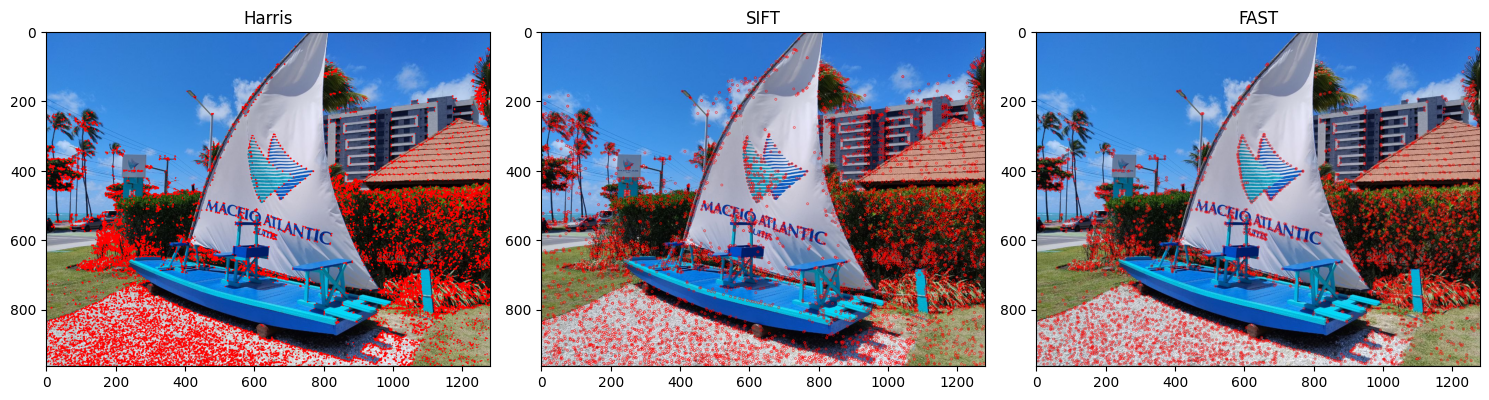

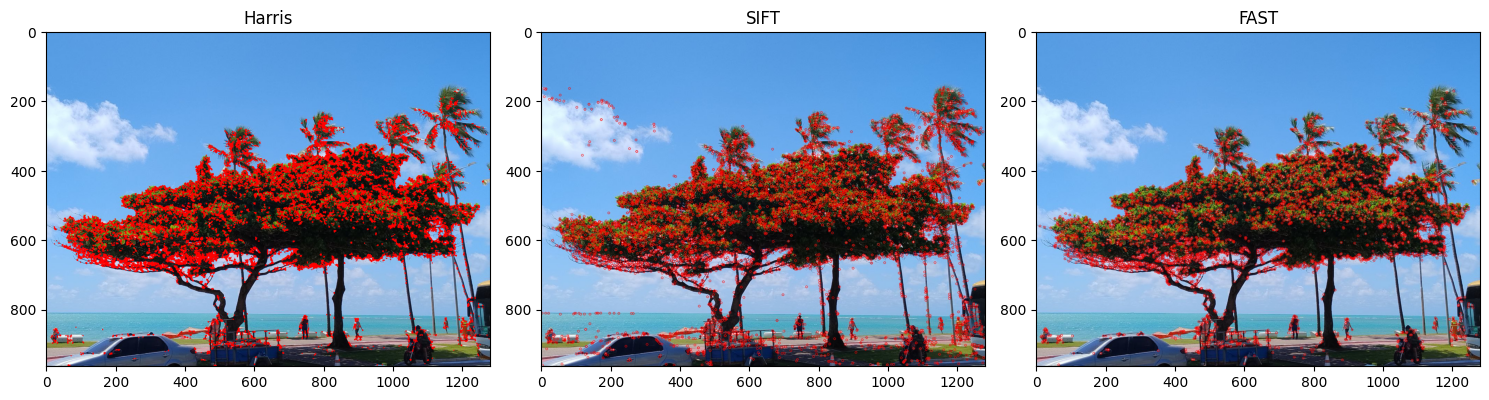

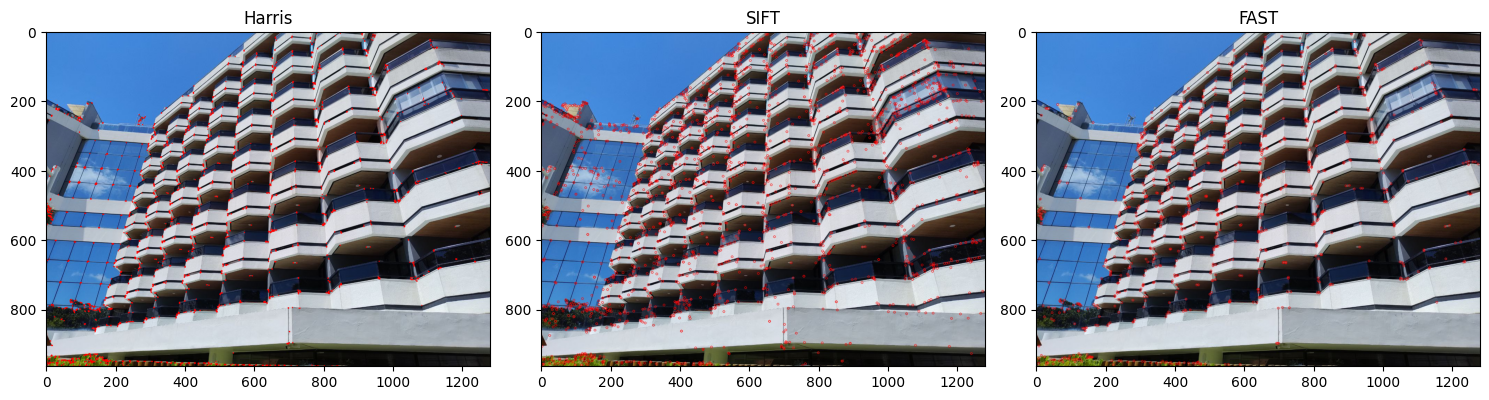

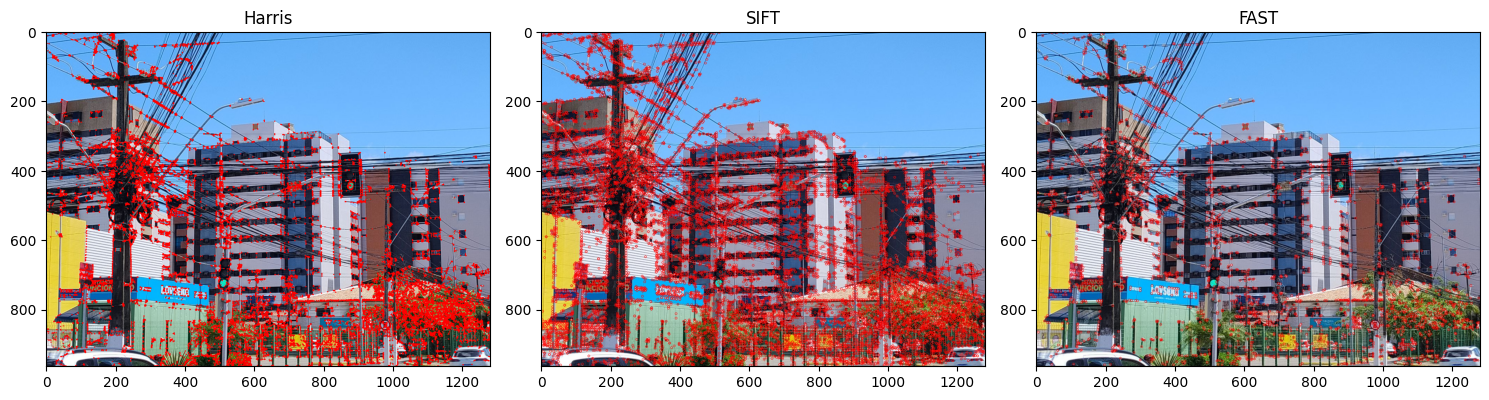

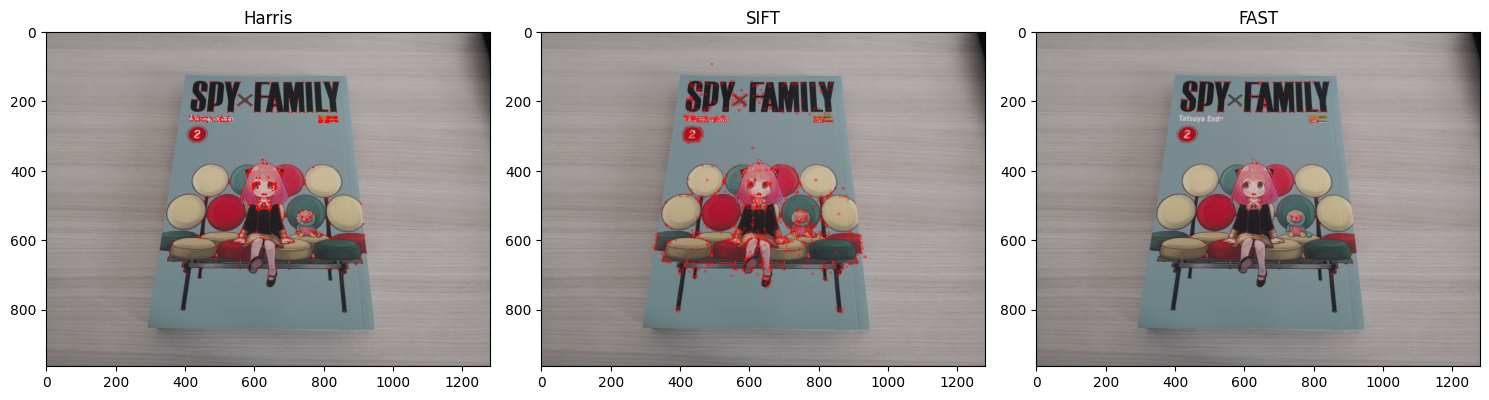

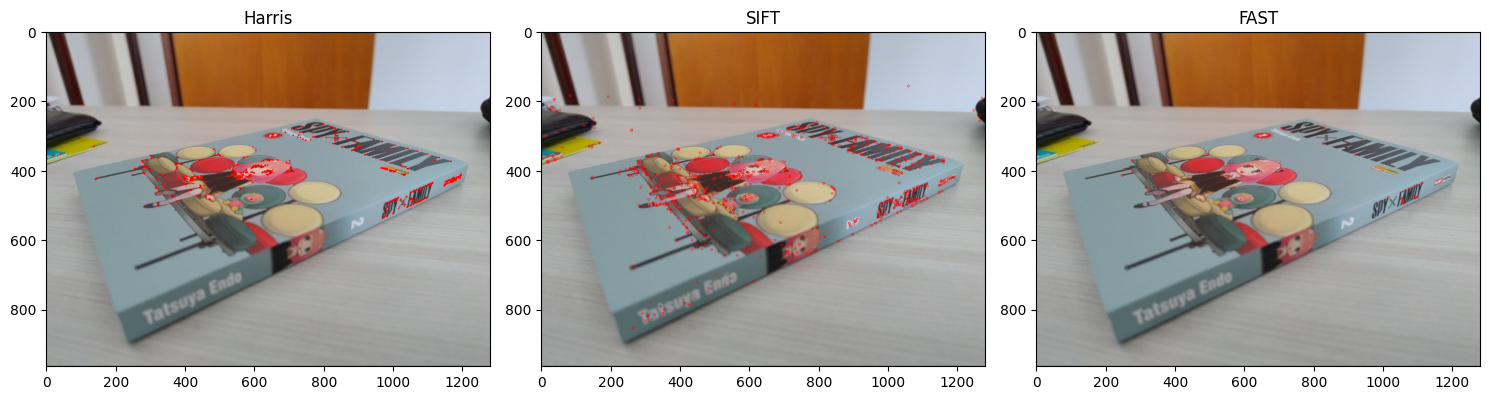

In [ ]:
def detect_feature_harris(img: cv.typing.MatLike, gray_img: cv.typing.MatLike):
    gray = np.float32(gray_img)
    dst = cv.cornerHarris(gray, 2, 3, 0.04)
    
    #result is dilated for marking the corners, not important
    dst = cv.dilate(dst, None)
    
    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()] = [0, 0, 255]
    
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)

def detect_feature_sift(img: cv.typing.MatLike, gray_img: cv.typing.MatLike):
    sift = cv.SIFT_create()
    kp = sift.detect(gray_img, None)

    return cv.drawKeypoints(cv.cvtColor(img, cv.COLOR_BGR2RGB), kp, None, color=(255, 0, 0), flags=0)

# def detect_feature_orb(img: cv.typing.MatLike, gray_img: cv.typing.MatLike):
#     orb = cv.ORB_create()
#     kp = orb.detect(gray_img, None)

#     return cv.drawKeypoints(cv.cvtColor(img, cv.COLOR_BGR2RGB), kp, None, color=(255, 0, 0), flags=0)

def detect_feature_fast(img: cv.typing.MatLike, gray_img: cv.typing.MatLike):
    fast = cv.FastFeatureDetector_create(threshold=70)
    kp = fast.detect(gray_img, None)
    return cv.drawKeypoints(cv.cvtColor(img, cv.COLOR_BGR2RGB), kp, None, color=(255, 0, 0), flags=0)

def detect_features(filename: str):
    img = cv.imread(filename)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    result = []

    # Detectores
    result.append(detect_feature_harris(img.copy(), gray))
    result.append(detect_feature_sift(img.copy(), gray))
    result.append(detect_feature_fast(img.copy(), gray))

    return result



# filenames = ['canoa', 'hotel', 'arvore', 'manga-1', 'manga-2', 'cocacola', 'tomada', 'semaforo']
filenames = ['canoa', 'arvore', 'hotel', 'semaforo', 'manga-1', 'manga-2']
for filename in filenames:
    result = detect_features(f'./assets/{filename}.jpg')
    show_images(*result, titles=['Harris', 'SIFT', 'FAST'], columns=3)



## Questão 2
Para essa etapa, foram selecionados os métodos SIFT, ORB e AKAZE. Além disso, foi utilizado o algoritmo de matching BFMatcher.

### SIFT
Já discutido na questão anterior.

### ORB
O ORB foi um algoritmo desenvolvido pela OpenCV como alternativa ao SIFT e SURF devido à questão de patentes (a patente do SIFT já venceu, mas o do SURF continua em vigor). Esse método usa uma versão modificada do FAST para detecção de features e uma versão modificada do BRIEF para geração dos descritores. 

As modificações desses algoritmos foram feitas por dois motivos: aumentar a eficiência do BRIEF e resolver o problema da não invariânvia a rotação. Para isso, ao gerar as features, o algoritmo computa também sua orientação (baseada no vetor que sai do ponto até o centróide de intensidade calculado para aquela janela). 

Além disso, também emprega a pirâmide de escala para garantir invariância de escala.

Os principais parâmetros são:
- Número de features (`nfeatures`): Controla a quantidade de features que vão ser detectadas
- Fator de escala (`scaleFactor`): Influencia na geração da pirâmide de escala. Quanto maior o valor, maior a robustez em relação à escala, mas maior o custo computacional.
- `WTA_K`: Número de features usados para criar um descritor (pode ser de 2 a 4)
- Limite do FAST (`fastThreshold`): Parâmetro threshold do FAST (discutido na questão anterior).

### AKAZE
O método AKAZE é uma versão melhorada do método KAZE, em termos de eficiência. Ele acaba sendo uma alternativa ao SURF, já que apresenta uma eficiência maior do que o SIFT, devido a utilização de descritores binários, e não está protegido por patentes. 

Embora não seja tão rápido quanto o ORB, apresenta um bom tradeoff entre velocidade e precisão, tendo resultados melhores para imagens com diferenças de iluminação, o que é resultado da utilização de difusão não linear na detecção de features (ao invés da pirâmide gaussiana).

Os principais arâmetros são:
- Limite (`threshold`): Determina a sensibilidade a detecção de features
- Número de octaves (`nOctaves`): Número de escalas na pirâmide.
- Número de camadas por octave (`nOctaveLayers`)
- Difusividade (`diffusivity`): Modelo de difusão não linear utilizada.

## Discussão
Os algoritmos foram utilizados com seus parâmetros nos valores default para evitar problemas na comparação. Além disso, em cada imagem foram imprimidas apenas as 14 melhores features para facilitar a visualização.

O primeiro par de imagens envolve uma rotação bastante severa, já que o mangá aparece num ângulo completamente diferente. Nesse caso, vemos que o SIFT foi o único que obteve resultados adequados. Apesar das modificações para aumentar a invariância a rotação, o matching do ORB ainda obteve resultados inadequados nesse caso, provavelmente devido à iluminação do ambiente ou ao baixo nível de detalhes da imagem, trata-se apenas de uma capa de livro com poucos desenhos. No caso do método AKAZE, os resultados foram ainda mais confusos. Ele acabou mapeando os sapatos da personagem com o batente da porta.

Diferente do observado para o caso do mangá, o resultado para as imagens externas foi o contrário. O SIFT, apesar de ainda obter um resultado adequado, acabou gerando alguns outliers, como foi o caso da imagem da academia, em que ele mapeou o chão de concreto à borda da janela do prédio que aparecer no fundo. Em relação aos outros dois, o match foi bem sucedido, sem nenhum outlier proeminente. Uma coisa a se observar é que o método AKAZE retornou um conjunto de matches mais diverso, enquanto o método ORB concentrou muito matches no mesmo local. 

Novamente, fica claro que o método ORB, assim como era o caso do FAST, seria mais adequado para aplicações de tempo real, em que o desempenho é crítico, uma vez que apresenta resultados inferiores aos demais. Apesar de apresentar resultados adequados nas imagens externas, ainda opteria pelo SIFT ao invés do AKAZE, justamente por conta da robustez em termos da rotação. As imagens externas usadas nessa atividade sofreram apenas translações (e ligeiras rotações), então a limitação do AKAZE não ficou tão aparente. Na minha opinião, o SIFT ainda é a melhor escolha (caso a aplicação não seja crítica em termos de desempenho), basta aplicar uma técnica de remoção de outliers.

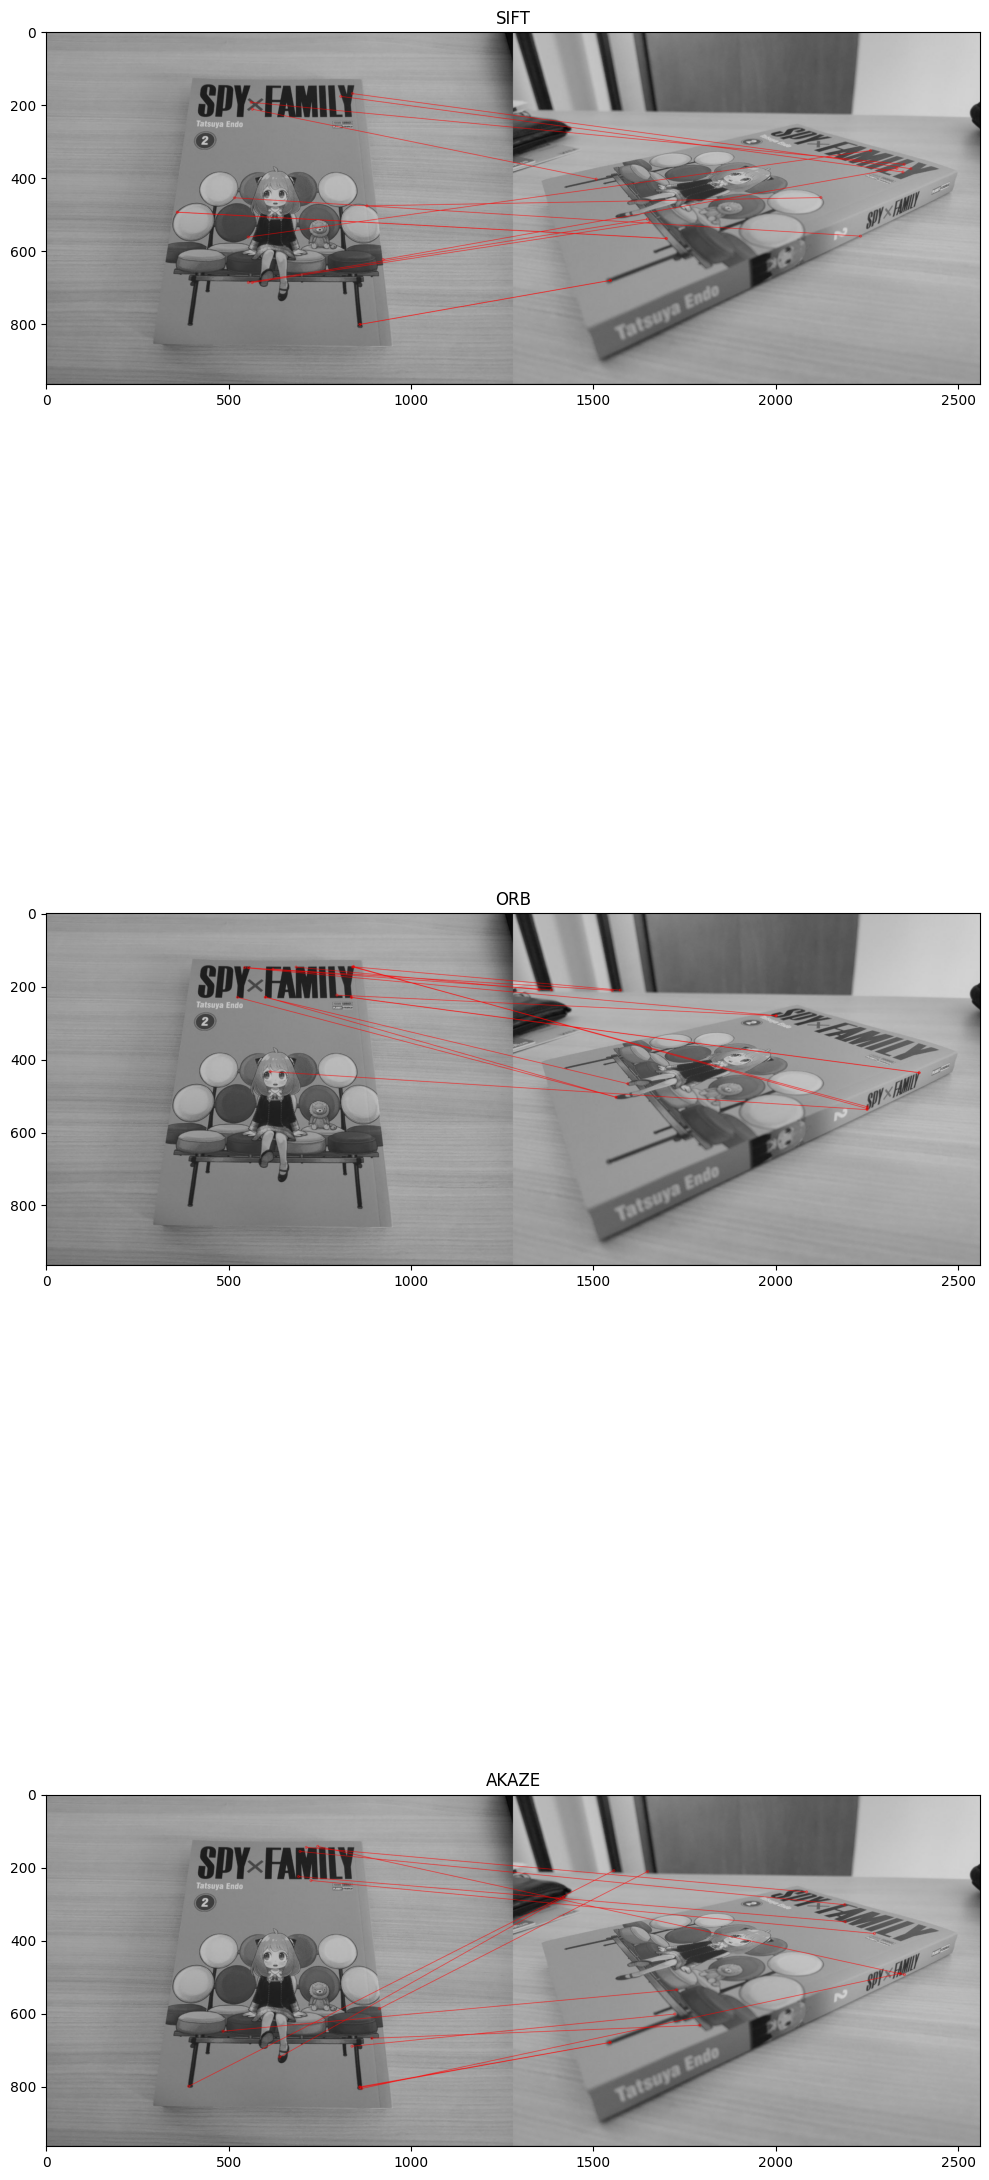

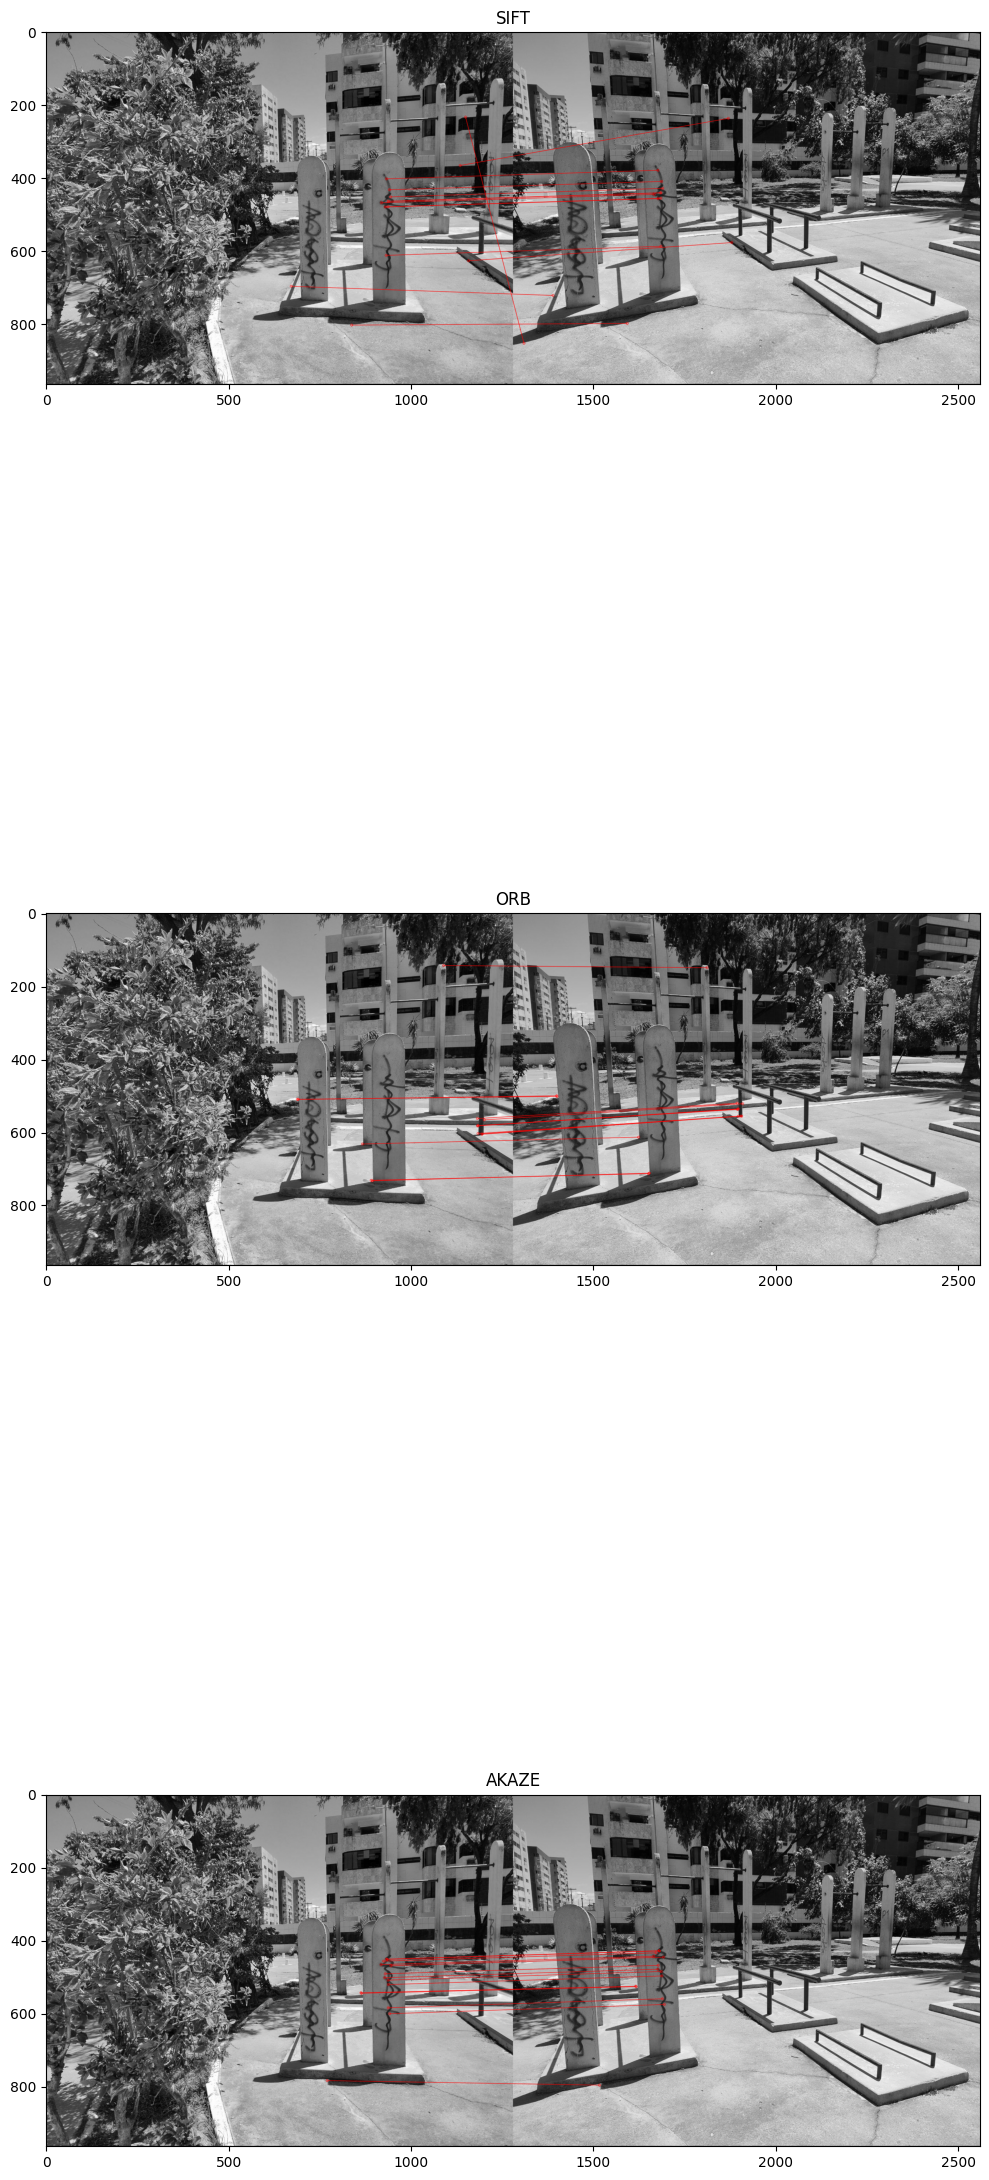

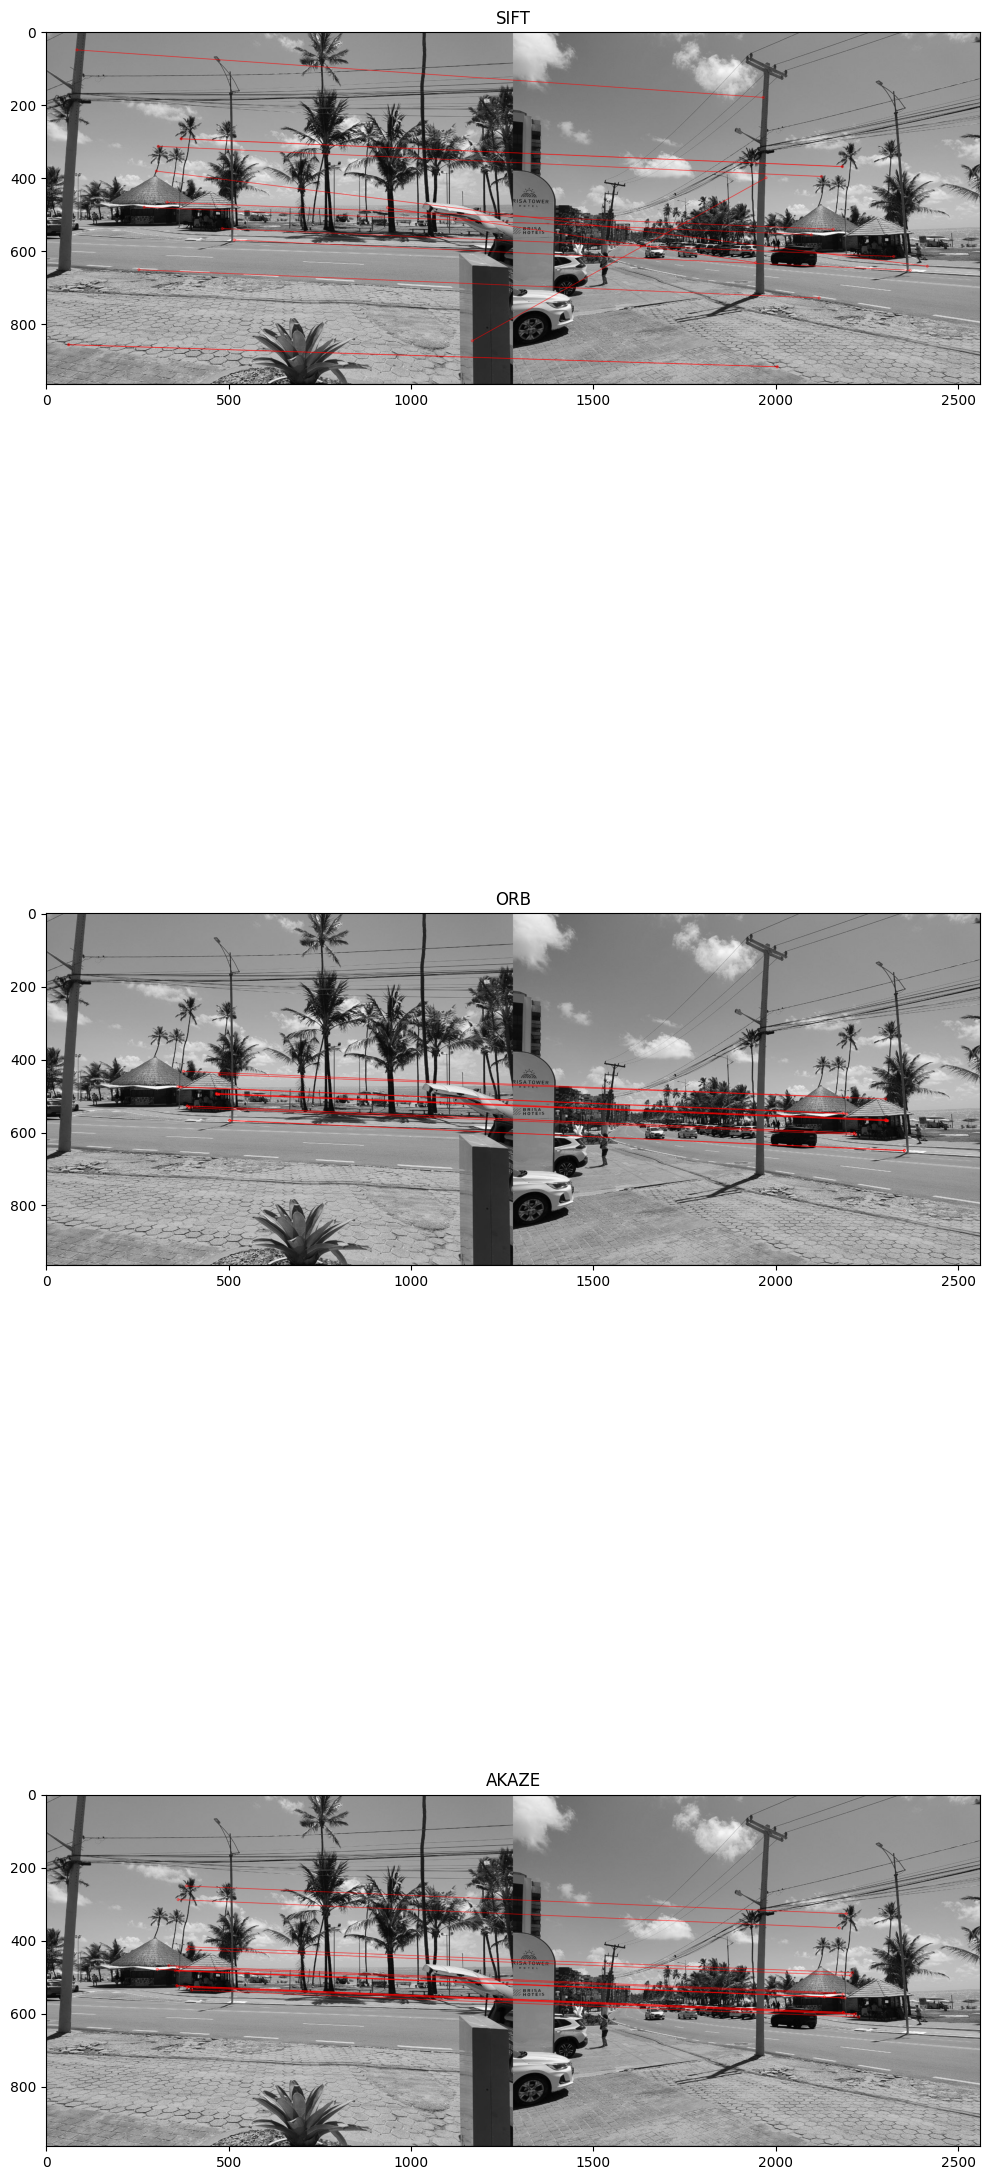

In [73]:
N_MATCHES = 14
def match_sift(img1: cv.typing.MatLike, img2: cv.typing.MatLike):
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv.BFMatcher(cv.NORM_L2, crossCheck=True)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:N_MATCHES], None, 
                          flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                          matchColor=[255, 0, 0])

    return img3

def match_orb(img1: cv.typing.MatLike, img2: cv.typing.MatLike):
    orb = cv.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:N_MATCHES], None, 
                          flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                          matchColor=[255, 0, 0])

    return img3

def match_akaze(img1: cv.typing.MatLike, img2: cv.typing.MatLike):
    akaze = cv.AKAZE_create()
    kp1, des1 = akaze.detectAndCompute(img1, None)
    kp2, des2 = akaze.detectAndCompute(img2, None)

    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

    matches = bf.match(des1, des2)
    matches = sorted(matches, key = lambda x:x.distance)
    
    img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:N_MATCHES], None, 
                          flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
                          matchColor=[255, 0, 0])

    return img3


def match_imgs(filename1: str, filename2: str):
    img1 = cv.imread(filename1, cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(filename2, cv.IMREAD_GRAYSCALE)
    
    result = []

    # Descritores
    result.append(match_sift(img1, img2))
    result.append(match_orb(img1, img2))
    result.append(match_akaze(img1, img2))

    return result



# filenames = ['canoa', 'hotel', 'arvore', 'manga-1', 'manga-2', 'cocacola', 'tomada', 'semaforo']
filenames = [('manga-1', 'manga-2'), ('gym-1', 'gym-2'), ('praia-1', 'praia-2')]
for filename1, filename2 in filenames:
    result = match_imgs(f'./assets/{filename1}.jpg', f'./assets/{filename2}.jpg')
    show_images(*result, titles=['SIFT', 'ORB', 'AKAZE'], columns=1, scale=10)